**This Notebook goes along with convnet_devp3.py. Compared to experiment2 notebook, it adds in L2 regularization on fully connected layers**

Note: implementation of Batch Normalization?

In [3]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from convnet_devp3 import *

### Load Data

In [4]:
train_dataset, train_labels, test_dataset, test_labels = load_data()

Loading the training data...
Loading the testing data...


### Split Training and Validation Data

In [5]:
train_dataset, valid_dataset, train_labels, valid_labels = \
    train_test_split(train_dataset, train_labels, test_size=10000,\
    random_state=897, stratify=train_labels)

### Reshape Data - 32x32x3¶

In [6]:
train_dataset = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_dataset = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_dataset = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Augmentation - 50% of training upside down flip; 50% mirror flip

In [7]:
# Dataset Parameters
image_size = 32
num_labels = 10
num_channels = 3
train_dataset, train_labels = preprocess_data(train_dataset, train_labels, num_labels)
valid_dataset, valid_labels = preprocess_data(valid_dataset, valid_labels, num_labels)
test_dataset,  test_labels  = preprocess_data(test_dataset,  test_labels,  num_labels)

### Generate a fixed small batch of data for corase tuning

In [8]:
train_batch_size = 32
valid_batch_size = 32
train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)

### Setup Network Parameters

In [9]:
# Parameters for building blocks
kernel_size3 = 3
kernel_size5 = 5
num_filter = 64
fc_size1 = 512

In [10]:
# Setup shapes for each layer in the convnet
convnet_shapes = [['conv1', [kernel_size5, kernel_size5, num_channels, num_filter]],
                  ['conv2', [kernel_size3, kernel_size3, num_filter, num_filter]],
                  ['conv3', [kernel_size5, kernel_size5, num_filter, num_filter]],
                  ['fc1'  , [(image_size/2/2/2)**2*num_filter, fc_size1]],
                  ['fc2'  , [fc_size1, num_labels]]]

In [13]:
model = convnet_stack
epoch = 501

In [12]:
hyperparams={'keep_prob': 1., 'init_lr': 0.003, 'decay_rate': .7, 'beta':0.01,
             'initializer':tf.truncated_normal_initializer(stddev=.015),
             'decay_steps':1000, 'optimizer':tf.train.AdamOptimizer}

In [29]:
graph = tf.Graph()
with graph.as_default():
    tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
               'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
               'test_X' : None, 'test_y': None}

In [28]:
import convnet_devp3
reload(convnet_devp3)
from convnet_devp3 import train_convnet

In [30]:
graph, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.338976	 Time cost: 0	Train Acc: 9.38%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 10:	 Loss: 2.229657	 Time cost: 0	Train Acc: 18.75%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 20:	 Loss: 2.161078	 Time cost: 0	Train Acc: 18.75%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 30:	 Loss: 2.123121	 Time cost: 0	Train Acc: 18.75%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 40:	 Loss: 2.101532	 Time cost: 0	Train Acc: 28.12%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 50:	 Loss: 2.071456	 Time cost: 0	Train Acc: 31.25%	Valid Acc:  9%	Learning rate: 0.000010/
Epoch: 60:	 Loss: 2.029851	 Time cost: 0	Train Acc: 31.25%	Valid Acc: 12%	Learning rate: 0.000010/
Epoch: 70:	 Loss: 1.971192	 Time cost: 0	Train Acc: 31.25%	Valid Acc: 12%	Learning rate: 0.000010/
Epoch: 80:	 Loss: 1.891571	 Time cost: 0	Train Acc: 40.62%	Valid Acc: 12%	Learning rate: 0

### Implement functions for random search - Log Space Search

In [52]:
def plot_data(data):
    epoch = range(data['train_losses'].shape[0])
    plt.subplot(211)
    plt.plot(epoch, data['train_losses'], label= 'training loss')
    plt.plot(epoch, data['valid_losses'], label='validation loss')
    plt.ylim([-.1,4])
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.plot(epoch, data['train_acc'], label='training accuracy')
    plt.plot(epoch, data['valid_acc'], label='validation accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='upper right')
    plt.show()

In [32]:
def random_search(num_experiments, train_batch_size, valid_batch_size, convnet_shapes, epoch):
    experiment_data = {}
    for i in range(num_experiments):
        # Prepare small batch of data for experimental training
        train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
        valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)
        # Sample random HyperParameters
        hyperparams = generate_hyperparams()
        # Prepare data for tensorflow
        graph = tf.Graph()
        with graph.as_default():
            tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
                       'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
                       'test_X' : None, 'test_y': None}
        hyperparams['initializer'] = tf.truncated_normal_initializer(stddev=hyperparams['init_std'])
        # Train convnet
        model = convnet_stack
        _, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)
        key = (hyperparams['keep_prob'], hyperparams['init_lr'], hyperparams['init_std'], hyperparams['beta'])
        experiment_data[key] = training_data
        print "Finished experiment ", str(i)
        print "="*100
    return experiment_data

In [83]:
def generate_hyperparams():
    # Generate random hyperparameters Log Space
    keep_prob = np.random.uniform(0.3, 0.7)
    init_lr = np.random.uniform(0.00005, 0.0003)
    init_std = np.random.uniform(0.01, 0.03)
    beta = 10**np.random.uniform(-4, -3) # original setting (-6, -1)
    hyperparams={'keep_prob': keep_prob, 'init_lr': init_lr, 'decay_rate': 1., 'decay_steps':1000,
                 'init_std': init_std, 'beta':beta, 'optimizer':tf.train.AdamOptimizer}
    return hyperparams

### Random Search Through Hyperparameter Space

In [65]:
num_exp = 1
train_batch_size = 64
valid_batch_size = 32
epoch = 301

In [90]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 3.505228	 Time cost: 1	Train Acc: 9.38%	Valid Acc:  6%	Learning rate: 0.000142/
Epoch: 10:	 Loss: 2.116494	 Time cost: 1	Train Acc: 25.00%	Valid Acc: 38%	Learning rate: 0.000142/
Epoch: 20:	 Loss: 1.575215	 Time cost: 1	Train Acc: 54.69%	Valid Acc: 34%	Learning rate: 0.000142/
Epoch: 30:	 Loss: 0.939574	 Time cost: 0	Train Acc: 71.88%	Valid Acc: 38%	Learning rate: 0.000142/
Epoch: 40:	 Loss: 0.590072	 Time cost: 0	Train Acc: 87.50%	Valid Acc: 34%	Learning rate: 0.000142/
Epoch: 50:	 Loss: 0.330733	 Time cost: 1	Train Acc: 93.75%	Valid Acc: 44%	Learning rate: 0.000142/
Epoch: 60:	 Loss: 0.162173	 Time cost: 0	Train Acc: 98.44%	Valid Acc: 44%	Learning rate: 0.000142/
Epoch: 70:	 Loss: 0.082529	 Time cost: 0	Train Acc: 100.00%	Valid Acc: 44%	Learning rate: 0.000142/
Epoch: 80:	 Loss: 0.065473	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 41%	Learning rate:

In [76]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.309571806745 		0.000126404254196 	0.0219711635064 	0.000152925896983 	0.375


In [63]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.469274904614 		0.000105678596781 	0.0271798853121 	1.24681200922e-05 	0.3125


In [92]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.400169955605 		0.000142452724142 	0.025945623948 		0.000551333584926 	0.40625


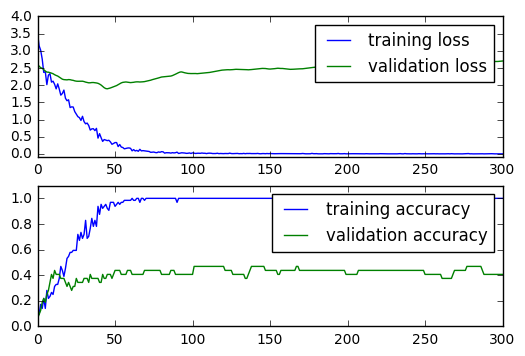

In [93]:
plot_data(exp_data)

***
### Summary
- Trail run parameters:
    - AdamOptimizer
    - Drop out keep prob: 0.4
    - Weights initialization: truncated_normal with stddev=0.015
    - Biases initialization : constant (1.0)
    - CONVNET architecture:
        * conv1: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool1: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv2: filter size 3x3, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool2: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv3: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool3: filter size 2x2, max pooling, stride=1, padding=SAME
        * fc1  : 512 neurons
        * fc2  : 10 neurons
    - Time cost per epoch:  secs
    - MiniBatch size: 512
    - Total epoches ran: 1200
    - learning rate: 0.0003, decay rate: 0.8, decay steps: 100, staircase: True
    - L2 regularization factor beta: 0.0001~0.0005